## Attacking MNIST Dataset

Here we use a custom NN trained on MNIST data to perform *Frank Wolf Black Box Attack*

## Environment setup

**1. Set current directory**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


**2. Import libraries**

In [3]:
import src.loss as customLoss
import src.dataset as data
import src.FWOptim as FWOptim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math


import torch
from src.models import MnistNet
from torchvision import transforms
from torch import nn, optim

In [ ]:
# Get cpu device
cpu = torch.device('cpu')
# Get best device, gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else cpu
device

device(type='cuda')

**3. Retrieve MNIST data**

We retrieve the MNIST data. <br>
The 'standard' *trasnform.compose* method just convert the data to *torch.Tensor* without any rescaling or normalizzation


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


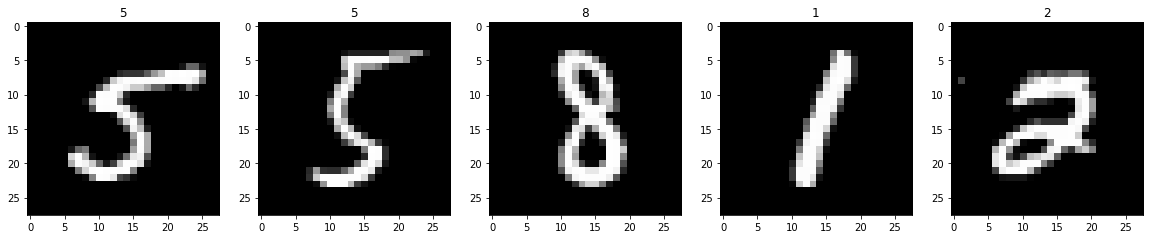

In [4]:
DataLoader = data.MNIST(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=250, num_workers=0)
DataLoader.get_info()

**4. Retrieve the network**


In [5]:
device = torch.device('cuda')
net = MnistNet().to(device)
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))

<All keys matched successfully>

### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Black-Box Frank-Wolfe Attack* to modify the image in order to make the network be mistaken.


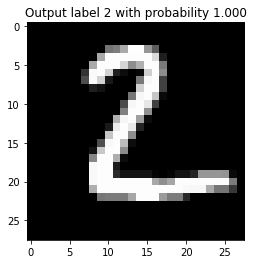

In [6]:
### Get an input used as test
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    break

net.eval()
img_orig = X[1].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[1].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

**5.2 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to manimize the probability of classification of neuron *zero*

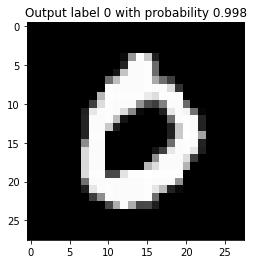

In [7]:
# 1. Choose image
index = 3

# 2. Define params
#solver = "adam"
solver = "newton"

params = {'x': X[index], 'c': 0.5, 'learning_rate': 3e-2, 
          'n_gradient': 128, 'solver': solver, 'max_steps': 10000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, 1, 28, 28)))
plt.imshow(np.transpose(img_orig, (1, 2, 0)).reshape(28, 28), cmap='gray')
original_label = torch.argmax(out_orig).item()
plt.title('Output label {} with probability {:.3f}'.format(original_label, float(out_orig[0, original_label])))
plt.show()

## Adversarial attack

### Single attack

### General attack

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

E.g. we try to minimize the probability of classification of neuron zero (0)

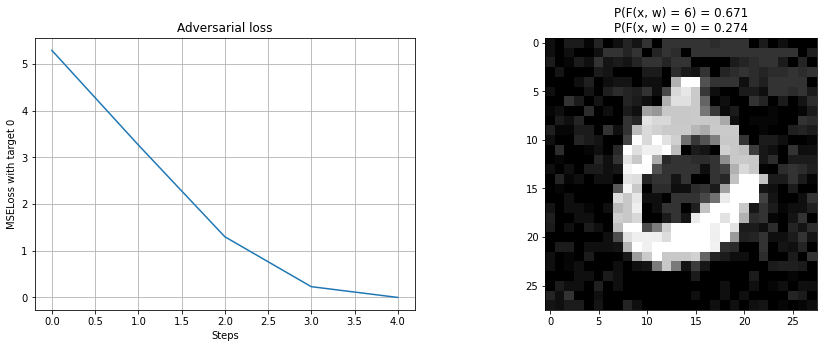

In [11]:
# Define output function
out_fn = torch.nn.Softmax(dim=1)
# Define loss function
loss_fn = customLoss.ZooLoss(neuron=0, maximise=0)
# Define optimizer
optim = FWOptim.FrankWolfe(net, loss_fn, 'cuda')

# Define optimizer parameters
optim_params = {
    'x': X[3],  # Input variable
    'm_weight': 0.2,  # Momentum weight (1 - gradient weight)
    'step_size': 0.2,  # Step size
    'num_epochs': 100,  # Number of epochs
    'l_bound': 0.3,  # Upper bound for l- norm
    'l_type': 'inf',  # l- norm type
    'grad_num_iter': 600,  # Number of inner iterations for gradient estimation
    'grad_smooth': 0.001,  # Gradient smoothing
    'grad_how': 'sphere',  # Gaussian estimation
    'grad_batch_size': 600,  # Size of the batch used in gradient estimation
    'verbose': False
}

# Disable gradient computation
with torch.no_grad():
    # Run the optimizer
    x, loss, _ = optim.run(**optim_params)
    # Compute last output
    out = out_fn(net(x.reshape(1, 1, 28, 28)))
    label = torch.argmax(out).item()
    img = x.detach().cpu().numpy()

# Show results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('MSELoss with target 0')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(label, float(out[0, label]),                                                                            original_label, float(out[0, original_label])))
plt.show()

### General attack

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

E.g. we want to try to maximise the probability of classification of neuron eight (8)

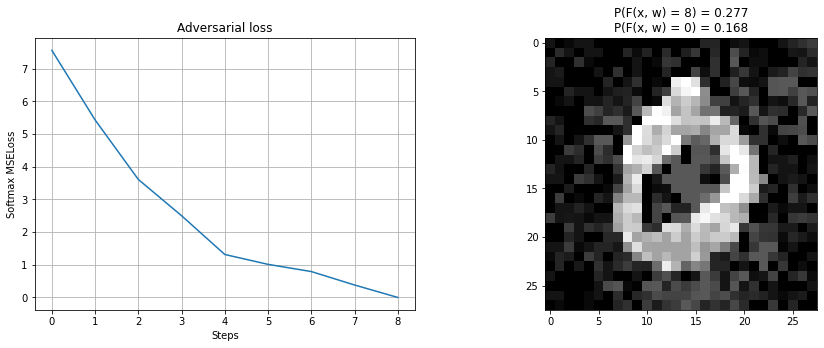

In [12]:
# Redefine loss function
# loss_fn = MSELoss(neuron=8, maximise=1)
loss_fn = customLoss.ZooLoss(neuron=8, maximise=1)
# Redefine optimizer
optim = FWOptim.FrankWolfe(net, loss_fn, 'cuda')

# Define optimizer parameters
optim_params = {
    'x': X[3],  # Input variable
    'm_weight': 0.2,  # Momentum weight (1 - gradient weight)
    'step_size': 0.2,  # Step size
    'num_epochs': 100,  # Number of epochs
    'l_bound': 0.4,  # Upper bound for l- norm
    'l_type': 'inf',  # l- norm type
    'grad_num_iter': 600,  # Number of inner iterations for gradient estimation
    'grad_smooth': 0.001,  # Gradient smoothing
    'grad_how': 'sphere',  # Gaussian estimation
    'grad_batch_size': 200,  # Size of the batch used in gradient estimation
    'verbose': False
}

# Disable gradient computation
with torch.no_grad():
    # Run the optimizer
    x, loss, _ = optim.run(**optim_params)
    # Compute manually last output
    out = out_fn(net(x.reshape(1, 1, 28, 28)))
    label = torch.argmax(out).item()
    img = x.detach().cpu().numpy()

# Show results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss)
ax[0].set_title('Adversarial loss')
ax[0].set_ylabel('Softmax MSELoss')
ax[0].set_xlabel('Steps')
ax[0].grid()
ax[1].imshow(img.reshape(28, 28), cmap='gray')
ax[1].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(
    label, float(out[0, label]), original_label, float(out[0, original_label]))
)
plt.show()